# Analytics in Yandex.Afisha

# Project Description
Objective: Help marketers optimize marketing costs.
You have at your disposal data from Yandex.Afisha from June 2017 to the end of May 2018:
server log with data on visits to the Yandex.Afisha website,
unloading of all orders for this period,
statistics of advertising costs.

Let's calculate:
- how people use  the product, 
- when they start buying,
- how much money each client brings,
- when does the CAC pay off.


## Step 1. Download the data and prepare it for analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
import decimal
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('visits_log.csv')

In [3]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders = pd.read_csv('orders_log.csv')

In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
costs = pd.read_csv('costs.csv')

In [9]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [11]:
visits.columns = ['device', 'end_time', 'source_id', 'start_time', 'uid']
orders.columns = ['buy_time', 'revenue', 'uid']
costs.columns = ['source_id', 'date', 'costs']

change data type on datetime:
visits: end_time, start_time
orders: buy_time
cost: date

In [12]:
visits['end_time'] = pd.to_datetime(visits['end_time'])
visits['start_time'] = pd.to_datetime(visits['start_time'])
orders['buy_time'] = pd.to_datetime(orders['buy_time'])
costs['date'] = pd.to_datetime(costs['date'])

#### visits :
- uid 
- device 
- start_time 
- end_time 
- source_id 

#### orders:
- Uuid 
- buy_time
- revenue 

#### costs:
- source_id
- date 
- costs

## Step 2. Build reports and calculate metrics

### Product
- How many people consume per day, week, month?
- How many lessons per day?
- How long does one lesson last?
- How often do people come back?

### Sales
- When do people start buying?
- How many times do they buy during the period?
- What is the average check?
- How much do they bring? (LTV)

### Marketing
- How much money did marketers spend? Total / by source / by time
- How much does it cost to attract one customer from each source?
- How much did the expenses pay off? (ROI)

## Product

In [13]:
visits['session_year'] = visits['start_time'].dt.year
visits['session_date'] = visits['start_time'].dt.date
visits['session_week'] = visits['start_time'].dt.week
visits['session_month'] = visits['start_time'].dt.month
visits['session_duration_sec'] = (visits['end_time'] - visits['start_time']).dt.seconds

In [14]:
visits.head(10)

,device,end_time,source_id,start_time,uid,session_year,session_date,session_week,session_month,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-20,51,12,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-19,8,2,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,7,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-20,20,5,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-27,52,12,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-03,35,9,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01-30,5,1,3360
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017,2017-11-05,44,11,60
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017,2017-07-19,29,7,180
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017,2017-11-08,45,11,60


We will calculate: 
- DAU (daily active users) 
- WAU (weekly active users)
- MAU (monthly active users)

In [15]:
dau = visits.groupby(['session_date']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
print('On average, {} users use the service per day'.format(int(dau)))
print('On average, {} users use the service per week'.format(int(wau)))
print('On average, {} users use the service per month'.format(int(mau)))

On average, 907 users use the service per day
On average, 5716 users use the service per week
On average, 23228 users use the service per month


In [16]:
day_visits = visits.groupby(['session_date']).agg({'uid':'count'})
print('On average, there are {} sessions per day'.format(int(day_visits.mean()[0])))

On average, there are 987 sessions per day


Let's calculate ASL (average session length):

In [17]:
ses_durat_mean = (visits['end_time'] - visits['start_time']).dt.seconds.mean()
print('On average, the duration of one session is {} seconds'.format(int(ses_durat_mean)))

On average, the duration of one session is 643 seconds


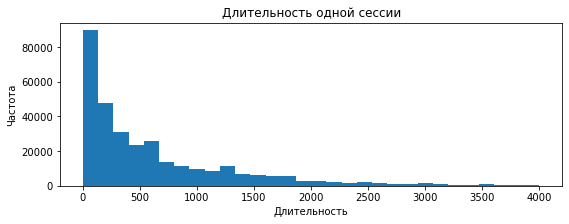

In [18]:
durations_of_visits = visits[visits['session_duration_sec'] != 0]['session_duration_sec']
durations_of_visits.plot(kind = 'hist', bins = 30, figsize = (9,3), range = (0, 4000))
plt.title('Длительность одной сессии')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

Our distribution is not close to normal, we cannot use the mean, so we calculate the mode: 

In [19]:
asl = visits['session_duration_sec'].mode()
print('On average, the duration of one session is {} seconds'.format(int(asl)))

On average, the duration of one session is 60 seconds


In [20]:
first_activity_date = visits.groupby('uid')['start_time'].min()
first_activity_date.name = 'first_session_month'
retention = visits.join(first_activity_date,on='uid')
retention['first_session_month'] = retention['first_session_month'].astype('datetime64[M]')
retention['session_month'] = retention['start_time'].astype('datetime64[M]')
retention['cohort_lifetime'] = retention['session_month'] - retention['first_session_month']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'M')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')
cohorts = (retention
                           .groupby(['first_session_month', 'cohort_lifetime'])
                           .agg({'uid': 'nunique'})
                           .reset_index())

In [21]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                          values='retention', aggfunc='sum')
retention_pivot.index = retention_pivot.index.strftime('%Y-%m')

In [22]:
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


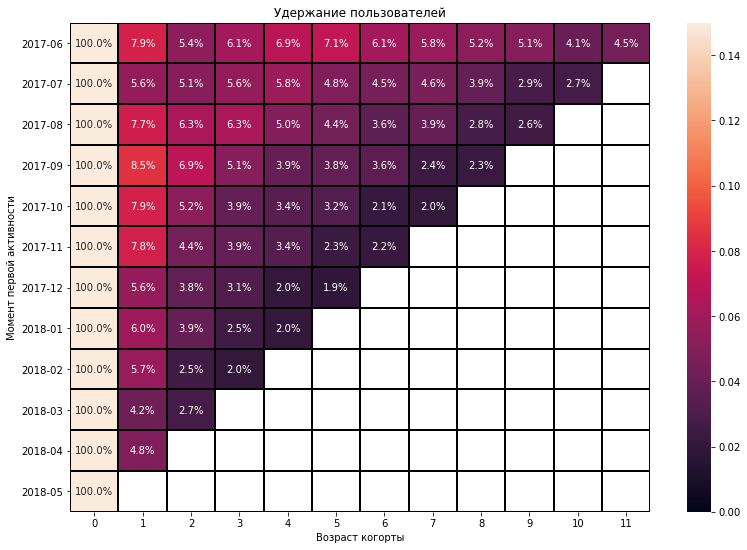

In [23]:
plt.figure(figsize=(13, 9))
plt.title('Удержание пользователей')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmin = 0, vmax = 0.15)
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Момент первой активности')
plt.show()

#### Conclusion: 

##### How many people use the product per a day,  a week, a month?

User Activity:
- daily: 907 users
- weekly: 23228 users
- monthly: 5716 users

###### How many sessions per day?

On average, there are 987 sessions per day

###### How long is one session?

The session duration is from 0 to 2 minutes. This means that users do not stay on the site for a long time, but leave it almost immediately.

###### How often do people come back?

Retention is pretty low. The indicator above 4% remains in all periods only in the first two cohorts. The retention of the next cohorts is rapidly decreasing to 2–3%, and it is likely that retention will be even lower in subsequent periods, based on the data of the new cohorts.







## Sales

In [24]:
#time and date of the first session
first_sessions = visits.groupby(['uid']).agg({'start_time':'min', 'uid':'first'})
first_sessions.columns = ['first_activity', 'first_source']

#time of first purchase
first_purchase = orders.groupby(['uid']).agg({'buy_time':'min'})
first_purchase.columns = ['first_buy_time']

#add the date and time of the first session
first_purchase = first_purchase.join(first_sessions,on='uid')

In [25]:
first_purchase['time_to_first_purchase'] = (first_purchase['first_buy_time'] -first_purchase['first_activity']) / np.timedelta64(1, 'm')

print('Median time from first session to first purchase: {} minutes'.format(int(first_purchase['time_to_first_purchase'].median())))
print('Average time from first session to first purchase: {} days'.format(int(first_purchase['time_to_first_purchase'].mean()/60/24)))

Median time from first session to first purchase: 16 minutes
Average time from first session to first purchase: 16 days


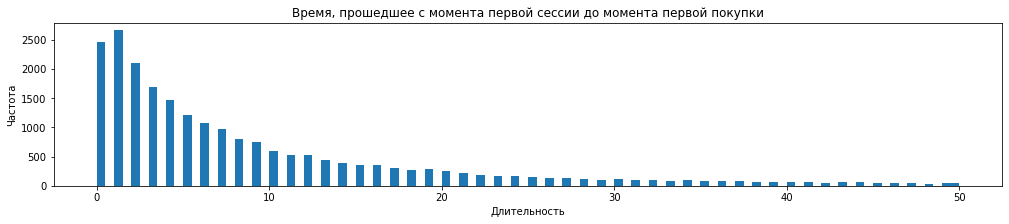

In [26]:
first_purchase['time_to_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3))
plt.title('Время, прошедшее с момента первой сессии до момента первой покупки')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()
plt.show()

The graph shows that most of it falls on the first 5 minutes, more precisely the first 3 minutes. Then there is a decline. Based on this, we can conclude that people visit the site for something specific, immediately find what they need and leave it.

In [27]:
first_purchase = orders.groupby('uid')['buy_time'].min().reset_index()
first_purchase.columns = ['uid', 'date_of_first_purchase']
order_frequency = pd.merge(orders, first_purchase, on='uid')
order_frequency.head(10)

,buy_time,revenue,uid,date_of_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00


In [28]:
def diff_month(row):
    date1 = row['buy_time']
    date2 = row['date_of_first_purchase']
    return (date1.year - date2.year) * 12 + date1.month - date2.month

order_frequency['time_diff'] = order_frequency.apply(diff_month, axis=1)
order_frequency['date_of_first_purchase'] = order_frequency['date_of_first_purchase'].astype('datetime64[M]')

In [29]:
purchases_grouped_by_cohorts = (order_frequency
                                                .groupby(['date_of_first_purchase','time_diff'])
                                                .agg({'buy_time': 'count', 'uid': 'nunique'})
                               )

purchases_grouped_by_cohorts['purchases_per_user'] = purchases_grouped_by_cohorts['buy_time']/purchases_grouped_by_cohorts['uid']
purchases_grouped_by_cohorts = purchases_grouped_by_cohorts.reset_index()
purchases_grouped_by_cohorts.head(10)

,date_of_first_purchase,time_diff,buy_time,uid,purchases_per_user
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,61,2.901639
2,2017-06-01,2,174,50,3.480000
3,2017-06-01,3,226,54,4.185185
4,2017-06-01,4,292,88,3.318182
5,2017-06-01,5,218,67,3.253731
6,2017-06-01,6,276,62,4.451613
7,2017-06-01,7,174,47,3.702128
8,2017-06-01,8,212,58,3.655172
9,2017-06-01,9,153,45,3.400000


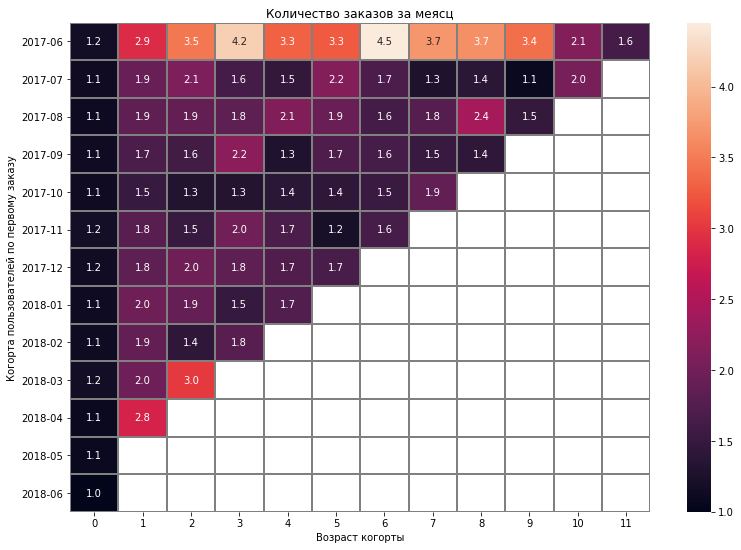

In [30]:
purchase_pivot = purchases_grouped_by_cohorts.pivot_table(index='date_of_first_purchase', 
                                                          columns='time_diff', 
                                                         values='purchases_per_user')
purchase_pivot.index = purchase_pivot.index.strftime('%Y-%m')
                            
plt.figure(figsize=(13, 9))
plt.title('Количество заказов за меясц')
ax = sns.heatmap(purchase_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей по первому заказу')
plt.show()

In [31]:
#average number of orders per month 
purchase_count_mean = order_frequency['revenue'].count() / 12 
print('The average number of orders per month for all users is {: .2f}'.format(purchase_count_mean))

The average number of orders per month for all users is  4201.25


In [32]:
#average number of orders per month per user
print('On average, there are {: .2f} orders per user a month'.format(purchase_pivot.mean().mean()))

On average, there are  1.92 orders per user a month


The first cohort is again the most active. On average, about three orders per month. As we can see, orders are not placed in the first month of using the service.
You can see outliers among the cohorts. Probably, during these periods something happened to study these events in more detail.

In [33]:
orders_month = orders.copy()
orders_month['buy_time'] = orders['buy_time'].astype('datetime64[M]')
fom = orders_month.groupby('uid').agg({'buy_time': 'min'}).reset_index()
fom.columns = ['uid', 'first_purchase_date']

cohort_sizes = fom.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']

fom_1 = orders_month.merge(fom, on='uid')
cohorts = (fom_1
                                    .groupby(['buy_time', 'first_purchase_date'])
                                    .agg({'revenue': 'sum', 'uid': 'count'})
                                    .reset_index()
          )
avg_check = cohorts.merge(cohort_sizes, on='first_purchase_date')
time_diff = avg_check['buy_time'] - avg_check['first_purchase_date']
avg_check['age'] = time_diff / np.timedelta64(1, 'M')
avg_check['age'] = avg_check['age'].round().astype('int')
avg_check['avg_check'] = avg_check['revenue']/avg_check['uid']


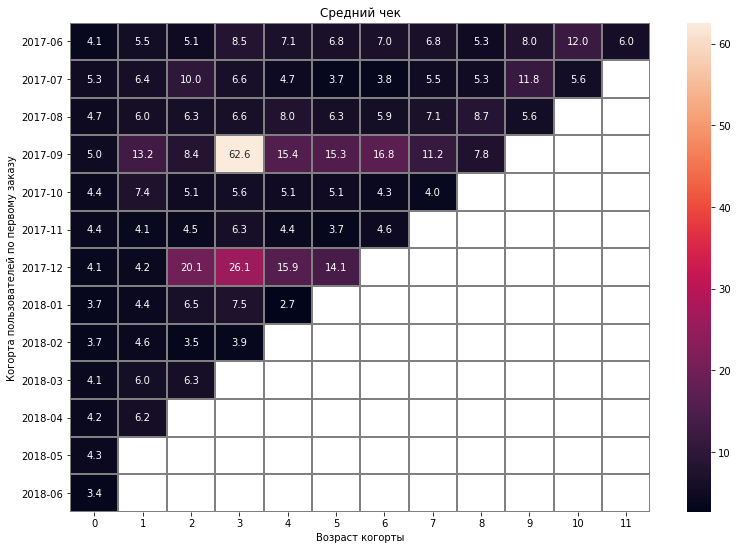

In [34]:
avg_check_pivot = avg_check.pivot_table(index='first_purchase_date', 
                                                          columns='age', 
                                                         values='avg_check')
avg_check_pivot.index = avg_check_pivot.index.strftime('%Y-%m')

                                                          
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
ax = sns.heatmap(avg_check_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей по первому заказу')
plt.show()

In [35]:
 print('Average bill {: .0f} thousand rubles'.format(avg_check['avg_check'].mean()))

Average bill  8 thousand rubles


Let's calculate LTV with a margin ratio equal to 1. It will be more convenient to calculate LTV by cohorts. Then, to calculate LTV, we divide the gross profit of the cohorts for each month by the total number of users in each cohort. Next, we create a pivot table and build a heatmap.

In [36]:
margin_rate = 1
report = cohorts.merge(cohort_sizes, on='first_purchase_date')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_time'] - report['first_purchase_date']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

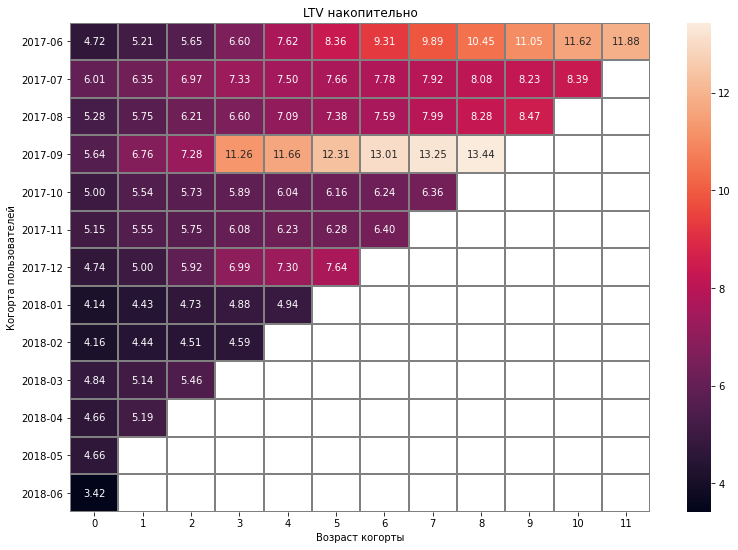

In [37]:
report_ltv_pivot = report.pivot_table(index='first_purchase_date', 
                                                          columns='age', 
                                                         values='ltv')
report_ltv_pivot.index = report_ltv_pivot.index.strftime('%Y-%m')
                                         
plt.figure(figsize=(13, 9))
plt.title('LTV накопительно')
ax = sns.heatmap(report_ltv_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей')
plt.show()

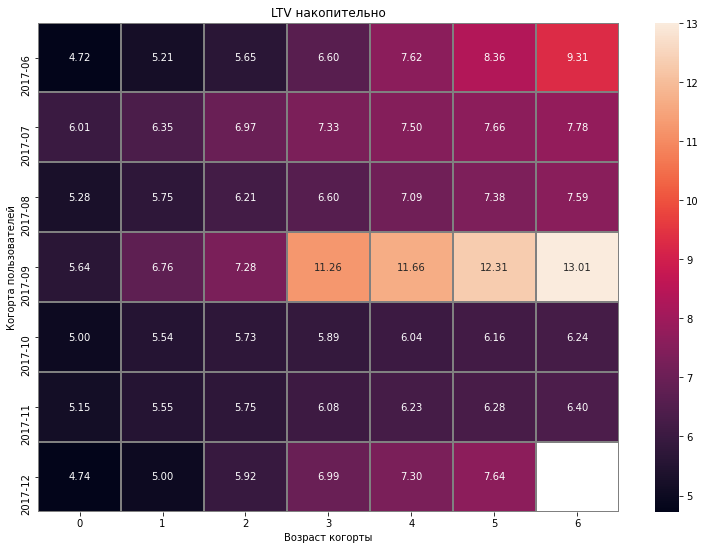

In [38]:
report['session_date'] = report['first_purchase_date'].astype('datetime64[M]')
filt_ltv = report.query('(session_date < 2018)&(age<=6)')
filt_pivot_ltv = filt_ltv.pivot_table(index='first_purchase_date', 
                                                          columns='age', 
                                                         values='ltv')
filt_pivot_ltv.index = filt_pivot_ltv.index.strftime('%Y-%m')
                                         
plt.figure(figsize=(13, 9))
plt.title('LTV накопительно')
ax = sns.heatmap(filt_pivot_ltv.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей')
plt.show()

#### Conclusion

##### When do people start buying?

The average purchase time since the start of the first session is 16 minutes, while the median time is 16 days.

###### How many times are purchased during the period?

- Average number of orders per month for all users is 4201.25
- On average there are 1.92 orders per user per month

###### What is the average bill?

The average bill is  8000 rubles.

###### How much money do they bring? (LTV)?

 The first cohort is the most revealing.

## Marketing

In [39]:
costs_sum = costs.copy()
costs_sum_grouped = costs_sum.groupby('date').agg({'costs': 'sum'})
orders_grouped = orders_month.groupby('buy_time').agg({'revenue': 'sum'})
data = {'sum': [round(orders_grouped.sum().values[0], 2),round(costs_sum_grouped.sum().values[0], 2)]}
costs_sum = pd.DataFrame(data=data, index=['revenue', 'costs'])

In [40]:
costs_sum

,sum
revenue,252057.20
costs,329131.62


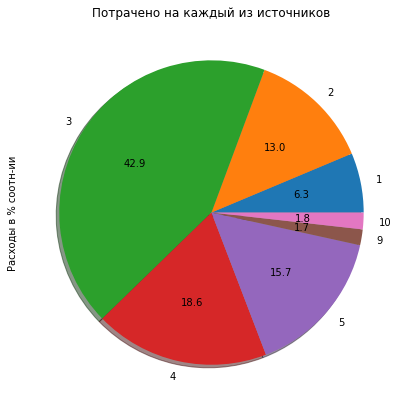

               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


In [41]:
costs['cost_month'] = costs['date'].astype('datetime64[M]')

costs.groupby('source_id').sum().plot(y = 'costs', autopct='%.1f', kind = 'pie', figsize = (7, 7), legend = False, shadow=True)
plt.title('Потрачено на каждый из источников')
plt.ylabel('Расходы в % соотн-ии')
plt.show()
print(costs.groupby('source_id').sum())

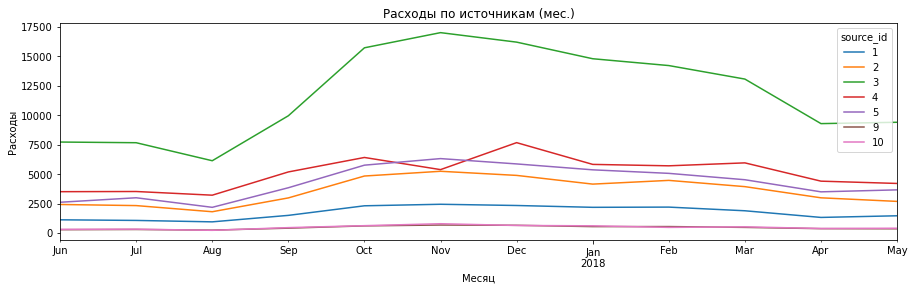

In [42]:
costs_pivot = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot.plot(figsize = (15,4), title = 'Расходы по источникам (мес.)')
plt.xlabel('Месяц')
plt. ylabel('Расходы')
plt.show()

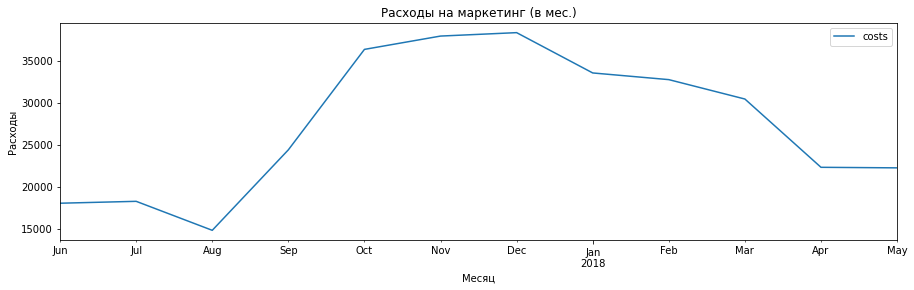

In [43]:
costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum').plot(title = 'Расходы на маркетинг (в мес.)', figsize = (15,4))
plt.xlabel('Месяц')
plt. ylabel('Расходы')
plt.show()

Since August 2017, we have been actively investing in advertising from all sources. The most active period is from October 2017 to March 2018. The most promoted source  is  3. 141 322 rubles were spent on it for the year.

In [44]:
visits_sorted = visits.sort_values(by='start_time') 
costs_source = costs.groupby('source_id').agg({'costs': 'sum'})
first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
user_per_source = orders.merge(first_source_per_user, on='uid')
user_per_source = user_per_source.groupby('source_id').agg({'uid': 'nunique'})
user_per_source = user_per_source.rename(columns={'uid': 'uid_user_per_source'})
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})
uid_per_source = uid_per_source.rename(columns={'uid': 'uid_per_source'})
cac_per_source = orders.merge(first_source_per_user, on='uid')
cac_per_source = cac_per_source.groupby('source_id').agg({'revenue': 'sum'})
cac = pd.concat([user_per_source, uid_per_source,cac_per_source, costs_source],axis=1).fillna(0)
cac['price_for_user'] = cac['costs']/cac['uid_user_per_source']
cac['price_for_user'].sort_values(ascending=False).round(2).sort_values(ascending=False).to_frame()

,price_for_user
source_id,
3,13.49
2,12.21
5,7.47
1,7.19
4,5.93
9,5.07
10,4.38
7,0.00
6,NaN


##### ROI

In [45]:
fom = orders_month.groupby('uid').agg({'buy_time': 'min'}).reset_index()
fom.columns = ['uid', 'first_purchase_date']
cohort_sizes = fom.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']
orders_fom = orders_month.merge(fom, on='uid')
cohorts = (orders_fom
                                    .groupby(['buy_time', 'first_purchase_date'])
                                    .agg({'revenue': 'sum'})
                                    .reset_index()
              )
margin_rate = 1
report = cohorts.merge(cohort_sizes, on='first_purchase_date')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_time'] - report['first_purchase_date']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

report_table = report.pivot_table(index="first_purchase_date",
                columns="age",
                values="ltv",
                aggfunc='mean')

In [46]:
costs_cac_for_romi = costs.copy()
costs_cac_for_romi['date'] = costs_cac_for_romi['date'].astype('datetime64[M]')
all_costs = costs_cac_for_romi.groupby('date')['costs'].sum().to_frame().reset_index()

report_new = report.merge(all_costs, left_on='first_purchase_date', right_on='date')

report_new['cac'] = report_new['costs']/report_new['n_buyers']
report_new['romi'] = (report_new['ltv']/report_new['cac'])

romi_pivot = report_new.pivot_table(index='first_purchase_date', columns='age',values='romi')
romi_pivot.index = romi_pivot.index.strftime('%Y-%m')

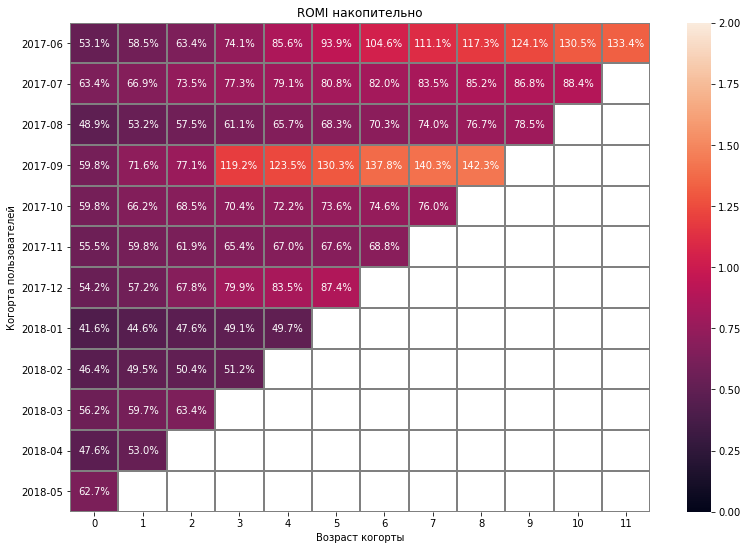

In [47]:
plt.figure(figsize=(13, 9))
plt.title('ROMI накопительно')
ax = sns.heatmap(romi_pivot.cumsum(axis=1), annot=True, fmt='.1%', 
                 linewidths=1, linecolor='gray', vmin=0, vmax=2)
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей')
plt.show()

In [48]:
report_new['session_date'] = report_new['first_purchase_date'].dt.year
filt_romi = report_new.query('(session_date < 2018)&(age<=6)')

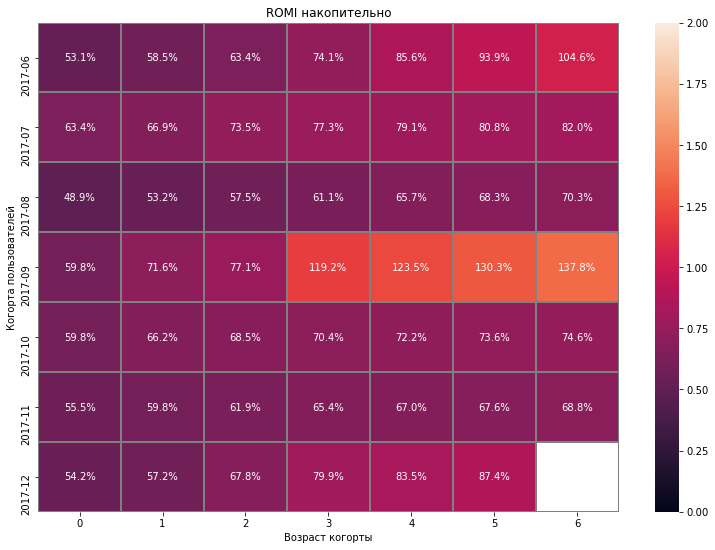

In [49]:
romi_pivot = filt_romi.pivot_table(index='first_purchase_date', columns='age',values='romi')
romi_pivot.index = romi_pivot.index.strftime('%Y-%m') 
plt.figure(figsize=(13, 9))
plt.title('ROMI накопительно')
ax = sns.heatmap(romi_pivot.cumsum(axis=1), annot=True, fmt='.1%', 
                 linewidths=1, linecolor='gray', vmin=0, vmax=2)
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей')
plt.show()

In [50]:
users_devices = visits.pivot_table(index = 'uid', columns = 'device', values = 'source_id', aggfunc = 'count')
data = {'device': ['ПК', 'Мобильные'], 
     'users': [len(users_devices.query('desktop == desktop')), 
               len(users_devices.query('touch == touch'))]}
users_devices_sum = pd.DataFrame(data=data)
users_devices_sum = users_devices_sum.set_index('device')
summary = users_devices_sum.values.sum()

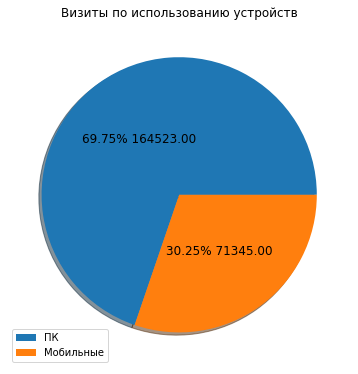

In [51]:
def pie_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}% {:.2f}".format(pct, value)
ax_pie = users_devices_sum.plot(kind='pie', y='users', fontsize=12, use_index=False, shadow=True,
                        title = 'Визиты по использованию устройств', pctdistance=0.5, figsize=(15,5), 
                        autopct=lambda pct: pie_pct(pct), labels=None)
plt.tight_layout(pad=0)
y_label = ax_pie.set_ylabel('')

## Step 3. Conclusion: Recommend to marketers where and how much should they invest?

On average, there are 987 sessions per day and the duration of a session is about 2 minutes. Users on the site do not stay long. This suggests that the user has a specific purpose for coming to the site. At the same time, Retention is quite low and decreases from 6% to 3% during the year. The average number of orders per month for all users is 4 201.
The average bill  is relatively small: 8 thousand rubles.

We also found that at this stage, the total costs exceed the revenue. Most of all investments fall on the 3rd source, it is also the most expensive source of attraction. Marketers should pay attention to the 4th source, which is the second most successful source of attraction, and is much cheaper than the first one.

I would like to draw your attention to the LTV of the 3rd month of life of cohorts, and to study this period in more detail, because It was during this period that there is a sharp jump in many cohorts; a good tendency is observed in the December cohort: it would probably show growth in the future.

With a marginality ratio of 1, only the September cohort paid off, and already in the 3rd month of life (we do not consider the first cohort in detail, since it will not be indicative). This suggests that the business is currently more unprofitable.


PC users use the site more than smartphone users. Which is very strange in the current realities. They are probably unhappy with the mobile application or the mobile version of the site. I would recommend marketers to consider developing a site towards smartphone apps. Then there will be much more users.

I recommend revising the invest  in advertising by source,  that you can understand why users return to the site again.

In general, the situation at the moment is not the worst , we have possobilites  for improvement. Marketers should focus on cheaper sources of acquisition. When using them, the service could have paid off long ago, but now, after analyzing the existing situation, we have identified points of growth and optimization.